# Fine-tune Llama 2 models on SageMaker JumpStart
In this notebook, we will perform instruction tuning Llama 2 using a subset of the Dolly 15k Dataset using Sagemaker Jumpstart.

This notebook as been put together based on an example from the Generative AI on AWS book https://github.com/generative-ai-on-aws/generative-ai-on-aws

# Setup 

In [1]:
! pip install datasets[s3]

## Deploy Pre-trained Model

---

First we will deploy the Llama-2 7B model as a SageMaker endpoint and do some inference.

---

In [2]:
model_id, model_version = "meta-textgeneration-llama-2-7b", "2.*"

In [3]:
from sagemaker.jumpstart.model import JumpStartModel

pretrained_model = JumpStartModel(model_id=model_id, model_version=model_version)
pretrained_predictor = pretrained_model.deploy()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


For forward compatibility, pin to model_version='2.*' in your JumpStartModel or JumpStartEstimator definitions. Note that major version upgrades may have different EULA acceptance terms and input/output signatures.
Using model 'meta-textgeneration-llama-2-7b' with wildcard version identifier '2.*'. You can pin to version '2.1.8' for more stable results. Note that models may have different input/output signatures after a major version upgrade.
For forward compatibility, pin to model_version='2.*' in your JumpStartModel or JumpStartEstimator definitions. Note that major version upgrades may have different EULA acceptance terms and input/output signatures.
Using model 'meta-textgeneration-llama-2-7b' with wildcard version identifier '2.*'. You can pin to version '2.1.8' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


---------------!

In [4]:
def print_response(payload, response):
    print(payload["inputs"])
    print(f"> {response[0]['generation']}")
    print("\n==================================\n")

In [5]:
payload = {
    "inputs": "I believe the meaning of life is",
    "parameters": {
        "max_new_tokens": 64,
        "top_p": 0.9,
        "temperature": 0.6,
        "return_full_text": False,
    },
}
try:
    response = pretrained_predictor.predict(payload, custom_attributes="accept_eula=true")
    print_response(payload, response)
except Exception as e:
    print(e)

I believe the meaning of life is
>  to be happy.
I think the meaning of life is to be happy.
I think the meaning of life is to be happy and make other people happy.
I think the meaning of life is to be happy and to make others happy.
I think the meaning of life is to be happy and make others




## Dataset preparation for fine-tuning

---

You can fine-tune on the dataset with domain adaptation format or instruction tuning format. We will use a subset of [Dolly dataset](https://huggingface.co/datasets/databricks/databricks-dolly-15k) in an instruction tuning format. Dolly dataset contains roughly 15,000 instruction following records for various categories such as question answering, summarization, information extraction etc. It is available under Apache 2.0 license. 

---

In [6]:
from datasets import load_dataset

# load training data set
dolly_dataset = load_dataset("databricks/databricks-dolly-15k", split="train")

# Filter for question answering examples
qa_dataset = dolly_dataset.filter(lambda example: example["category"] == "closed_qa")
qa_dataset = qa_dataset.remove_columns("category")



In [7]:
import matplotlib.pyplot as plt

def plot_and_filter_sequence_lengths(dataset_obj, max_length=2200):

    # Initialize a list to store the sequence lengths
    sequence_lengths = []

    # list of indices that are too long
    too_long = []

    # Loop over the dataset and get the lengths of text sequences
    for idx, example in enumerate(dataset_obj):
        sequence_lengths.append(len(example['instruction']) + len(example["context"]) + len(example["response"]))
        if sequence_lengths[idx] > max_length:
          too_long.append(idx)

    # Plot the histogram
    plt.hist(sequence_lengths, bins=30)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Text Sequence Lengths')
    plt.show()

    return too_long

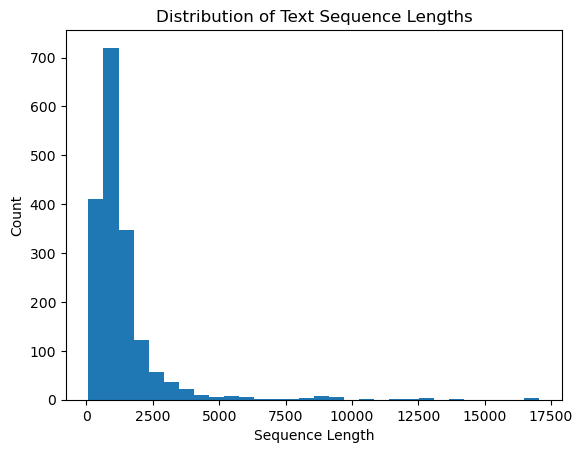

In [8]:
# filter long tail of very long instances
indexes_to_drop = plot_and_filter_sequence_lengths(qa_dataset, max_length=1000)

In [9]:
qa_dataset_reduced = qa_dataset.select(
    i for i in range(len(qa_dataset)) if i not in set(indexes_to_drop)
)

Parameter 'indices'=<generator object <genexpr> at 0x7fb994184510> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [10]:
qa_dataset_reduced

Dataset({
    features: ['instruction', 'context', 'response'],
    num_rows: 935
})

In [13]:
import pprint

# We split the dataset into two where test data is used to evaluate at the end.
train_and_test_dataset = qa_dataset_reduced.train_test_split(test_size=0.1)
train_dataset = train_and_test_dataset["train"]

# Dumping the training data to a local file to be used for training.
train_dataset.to_json("training.jsonl")

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(train_dataset[0])

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

{   'context': 'Kilo is a station on the VR commuter rail network on the '
               'Rantarata line located in Kilo, a district of the city of '
               'Espoo in Finland. It is situated between Leppävaara railway '
               'station and Kera railway station, approximately 13 kilometres '
               '(8.1 mi) northwest/west of Helsinki Central railway station.',
    'instruction': 'Where is the Kilo railway station',
    'response': 'Kilo is a station on the VR commuter rail network on the '
                'Rantarata line located in Kilo, a district of the city of '
                'Espoo in Finland. It is situated between Leppavaara railway '
                'station and Kera railway station, approximately 13 kilometres '
                '(8.1 mi) northwest/west of Helsinki Central railway station.'}


---
Next, we create a prompt template for using the data in an instruction / input format for the training job.

In [14]:
import json

template = {
    "prompt": "Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Input:\n{context}\n\n",
    "completion": "{response}",
}
with open("template.json", "w") as f:
    json.dump(template, f)

### Upload dataset to S3
---

We will upload the prepared dataset to S3 which will be used for fine-tuning.

---

In [15]:
from sagemaker.s3 import S3Uploader
import sagemaker
import random

bucket = sagemaker.Session().default_bucket()
local_data_file = "training.jsonl"
train_data_location = f"s3://{bucket}/dolly_dataset"
S3Uploader.upload(local_data_file, train_data_location)
S3Uploader.upload("template.json", train_data_location)
print(f"Training data: {train_data_location}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Training data: s3://sagemaker-us-east-1-703877312554/dolly_dataset


# Train the model

Next, we fine-tune the LLaMA v2 7B model. Finetuning scripts are based on scripts provided by [this repo](https://github.com/facebookresearch/llama-recipes/tree/main).


In [16]:
from sagemaker.jumpstart.estimator import JumpStartEstimator

estimator = JumpStartEstimator(
    model_id=model_id,
    model_version=model_version,
    instance_type="ml.g5.12xlarge",
    instance_count=1,
    environment={"accept_eula": "true"}
)

# By default, instruction tuning is set to false
estimator.set_hyperparameters(instruction_tuned="True", 
                              epoch="1", 
                              max_input_length="1024")
estimator.fit({"training": train_data_location})

INFO:sagemaker:Creating training-job with name: meta-textgeneration-llama-2-7b-2024-01-20-10-11-13-459


2024-01-20 10:11:13 Starting - Starting the training job...
2024-01-20 10:11:21 Pending - Training job waiting for capacity...
2024-01-20 10:11:57 Pending - Preparing the instances for training....................................
2024-01-20 10:18:15 Downloading - Downloading input data................................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-01-20 10:23:23,524 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-01-20 10:23:23,584 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-01-20 10:23:23,593 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-01-20 10:23:23,595 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-01-20 10:23:31,460 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/opt/conda/bin/python

### Deploy the fine-tuned model
---
Next, we deploy fine-tuned model. We will compare the performance of fine-tuned and pre-trained model.

---

In [17]:
finetuned_predictor = estimator.deploy()

INFO:sagemaker.jumpstart:No instance type selected for inference hosting endpoint. Defaulting to ml.g5.2xlarge.
INFO:sagemaker.jumpstart:No instance type selected for inference hosting endpoint. Defaulting to ml.g5.2xlarge.
INFO:sagemaker:Creating model with name: meta-textgeneration-llama-2-7b-2024-01-20-11-22-57-257
INFO:sagemaker:Creating endpoint-config with name meta-textgeneration-llama-2-7b-2024-01-20-11-22-57-254
INFO:sagemaker:Creating endpoint with name meta-textgeneration-llama-2-7b-2024-01-20-11-22-57-254


-------------!

### Evaluate the pre-trained and fine-tuned model
---
Next, we use the test data to evaluate the performance of the fine-tuned model and compare it with the pre-trained model. 

---

In [18]:
import pandas as pd
from IPython.display import display, HTML

test_dataset = train_and_test_dataset["test"]

inputs, ground_truth_responses, responses_before_finetuning, responses_after_finetuning = (
    [],
    [],
    [],
    [],
)


def predict_and_print(datapoint):
    # For instruction fine-tuning, we insert a special key between input and output
    input_output_demarkation_key = "\n\n### Response:\n"

    instruction = f"### Instruction {datapoint['instruction']}"
    context = f"### Context\n{datapoint['context']}" 
    prompt = "\n\n".join([i for i in [instruction, context] if i is not None])
    
    payload = {
        #"inputs": template["prompt"].format(
        "inputs": prompt.format(
            instruction=datapoint["instruction"], context=datapoint["context"]
        )
        + input_output_demarkation_key,
        "parameters": {"max_new_tokens": 100},
    }
    inputs.append(payload["inputs"])
    ground_truth_responses.append(datapoint["response"])
    # Please change the following line to "accept_eula=True"
    pretrained_response = pretrained_predictor.predict(
        payload, custom_attributes="accept_eula=true"
    )
    responses_before_finetuning.append(pretrained_response[0]["generation"])
    # Please change the following line to "accept_eula=True"
    finetuned_response = finetuned_predictor.predict(payload, custom_attributes="accept_eula=true")
    responses_after_finetuning.append(finetuned_response[0]["generation"])


try:
    for i, datapoint in enumerate(test_dataset.select(range(5))):
        predict_and_print(datapoint)

    df = pd.DataFrame(
        {
            "Inputs": inputs,
            "Ground Truth": ground_truth_responses,
            "Response from non-finetuned model": responses_before_finetuning,
            "Response from fine-tuned model": responses_after_finetuning,
        }
    )
    display(HTML(df.to_html()))
except Exception as e:
    print(e)

,Inputs,Ground Truth,Response from non-finetuned model,Response from fine-tuned model
0,"### Instruction What is Milky Way?\n\n### Context\nThe Milky Way is the galaxy that includes the Solar System, with the name describing the galaxy's appearance from Earth: a hazy band of light seen in the night sky formed from stars that cannot be individually distinguished by the naked eye. The term Milky Way is a translation of the Latin via lactea, from the Greek γαλακτικὸς κύκλος (galaktikòs kýklos), meaning ""milky circle"". From Earth, the Milky Way appears as a band because its disk-shaped structure is viewed from within. Galileo Galilei first resolved the band of light into individual stars with his telescope in 1610. Until the early 1920s, most astronomers thought that the Milky Way contained all the stars in the Universe. Following the 1920 Great Debate between the astronomers Harlow Shapley and Heber Doust Curtis, observations by Edwin Hubble showed that the Milky Way is just one of many galaxies.\n\n### Response:\n",Milky Way is the galaxy that includes Solar System in which our planet Earth is located.,"\n* I can’t see anything\n\n### Instruction What is The Big Bang?\n\n### Context\n\nThe Big Bang theory is an early cosmological model of the universe based on the general theory of relativity, which states that space and time emerged together 13.8 billion years ago with a singularity. The Big Bang theory is the prevailing cosmological model for the universe from the earliest known periods through its subsequent large-scale evolution.[1","The Milky Way galaxy is an example of a barred spiral galaxy. It has a bulge at its center and two spiral arms that wind outward with logarithmic patterns toward the poles of the galaxy. The Milky Way is the galaxy that includes the Solar System, with the name describing the galaxy's appearance from Earth: a hazy band of light seen in the night sky formed from stars that cannot be individually distinguished by the naked"
1,"### Instruction What is the capital of Mongolia?\n\n### Context\nMongolia (/mɒŋˈɡoʊliə/ (listen)) is a landlocked country in East Asia, bordered by Russia to the north and China to the south. It covers an area of 1,564,116 square kilometres (603,909 square miles), with a population of just 3.3 million, making it the world's most sparsely populated sovereign nation. Mongolia is the world's largest landlocked country that does not border a closed sea, and much of its area is covered by grassy steppe, with mountains to the north and west and the Gobi Desert to the south. Ulaanbaatar, the capital and largest city, is home to roughly half of the country's population.\n\n### Response:\n",Ulaanbaatar is the capital of Mongolia,"\n* Mongolia's capital is Ulan Bator.\n\n## Answer 2\n\nWould you like to fly on an Air France flights?\n\n### Instruction\n\n### Context\nAir France (AF, originally Société Air France) is a French airline headquartered in Tremblay-en-France. It is a subsidiary of Air France–KLM created after the 2004 French Airline Indust",The capital of Mongolia is Ulaanbaatar.
2,"### Instruction Here is some reference information about Huaquechula, When does the feast of the Holy Cross in Huaquechula start?\n\n### Context\nOne major festival is that of the Feast of the Holy Cross, which dates back far into the colonial period. It has a community cross made from basalt called the “Cruz de Huaquechula” which is incrusted with various relics related to the original cross of Christ. It is said to be so heavy that it cannot be lifted unless the bearers pray and the church plays a special melody on its bells. The festival lasts nine days beginning in April ending on May 3, with mass, traditional dance, food and music played by bands playing wind instruments, and fireworks set off from large frames in the shape bulls. The event has been named part of the Cultural Heritage of Puebla. During this event, traditional festive wear such as that of the charro and the China Poblana can

### Clean up resources

In [19]:
# Delete resources
pretrained_predictor.delete_model()
pretrained_predictor.delete_endpoint()
finetuned_predictor.delete_model()
finetuned_predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: meta-textgeneration-llama-2-7b-2024-01-20-10-00-02-544
INFO:sagemaker:Deleting endpoint configuration with name: meta-textgeneration-llama-2-7b-2024-01-20-10-00-02-697
INFO:sagemaker:Deleting endpoint with name: meta-textgeneration-llama-2-7b-2024-01-20-10-00-02-697
INFO:sagemaker:Deleting model with name: meta-textgeneration-llama-2-7b-2024-01-20-11-22-57-257
INFO:sagemaker:Deleting endpoint configuration with name: meta-textgeneration-llama-2-7b-2024-01-20-11-22-57-254
INFO:sagemaker:Deleting endpoint with name: meta-textgeneration-llama-2-7b-2024-01-20-11-22-57-254


# What to do next
- Understand the various parameters in finetuning

# Appendix


### Supported Inference Parameters

---
This model supports the following inference payload parameters:

* **max_new_tokens:** Model generates text until the output length (excluding the input context length) reaches max_new_tokens. If specified, it must be a positive integer.
* **temperature:** Controls the randomness in the output. Higher temperature results in output sequence with low-probability words and lower temperature results in output sequence with high-probability words. If `temperature` -> 0, it results in greedy decoding. If specified, it must be a positive float.
* **top_p:** In each step of text generation, sample from the smallest possible set of words with cumulative probability `top_p`. If specified, it must be a float between 0 and 1.
* **return_full_text:** If True, input text will be part of the output generated text. If specified, it must be boolean. The default value for it is False.

You may specify any subset of the parameters mentioned above while invoking an endpoint. 


### Notes
- If `max_new_tokens` is not defined, the model may generate up to the maximum total tokens allowed, which is 4K for these models. This may result in endpoint query timeout errors, so it is recommended to set `max_new_tokens` when possible. For 7B, 13B, and 70B models, we recommend to set `max_new_tokens` no greater than 1500, 1000, and 500 respectively, while keeping the total number of tokens less than 4K.
- In order to support a 4k context length, this model has restricted query payloads to only utilize a batch size of 1. Payloads with larger batch sizes will receive an endpoint error prior to inference.

---

### Supported Hyper-parameters for fine-tuning
---
- epoch: The number of passes that the fine-tuning algorithm takes through the training dataset. Must be an integer greater than 1. Default: 5
- learning_rate: The rate at which the model weights are updated after working through each batch of training examples. Must be a positive float greater than 0. Default: 1e-4.
- instruction_tuned: Whether to instruction-train the model or not. Must be 'True' or 'False'. Default: 'False'
- per_device_train_batch_size: The batch size per GPU core/CPU for training. Must be a positive integer. Default: 4.
- per_device_eval_batch_size: The batch size per GPU core/CPU for evaluation. Must be a positive integer. Default: 1
- max_train_samples: For debugging purposes or quicker training, truncate the number of training examples to this value. Value -1 means using all of training samples. Must be a positive integer or -1. Default: -1. 
- max_val_samples: For debugging purposes or quicker training, truncate the number of validation examples to this value. Value -1 means using all of validation samples. Must be a positive integer or -1. Default: -1. 
- max_input_length: Maximum total input sequence length after tokenization. Sequences longer than this will be truncated. If -1, max_input_length is set to the minimum of 1024 and the maximum model length defined by the tokenizer. If set to a positive value, max_input_length is set to the minimum of the provided value and the model_max_length defined by the tokenizer. Must be a positive integer or -1. Default: -1. 
- validation_split_ratio: If validation channel is none, ratio of train-validation split from the train data. Must be between 0 and 1. Default: 0.2. 
- train_data_split_seed: If validation data is not present, this fixes the random splitting of the input training data to training and validation data used by the algorithm. Must be an integer. Default: 0.
- preprocessing_num_workers: The number of processes to use for the preprocessing. If None, main process is used for preprocessing. Default: "None"
- lora_r: Lora R. Must be a positive integer. Default: 8.
- lora_alpha: Lora Alpha. Must be a positive integer. Default: 32
- lora_dropout: Lora Dropout. must be a positive float between 0 and 1. Default: 0.05. 
- int8_quantization: If True, model is loaded with 8 bit precision for training. Default for 7B/13B: False. Default for 70B: True.
- enable_fsdp: If True, training uses Fully Sharded Data Parallelism. Default for 7B/13B: True. Default for 70B: False.

Note 1: int8_quantization is not supported with FSDP. Also, int8_quantization = 'False' and enable_fsdp = 'False' is not supported due to CUDA memory issues for any of the g5 family instances. Thus, we recommend setting exactly one of int8_quantization or enable_fsdp to be 'True'
Note 2: Due to the size of the model, 70B model can not be fine-tuned with enable_fsdp = 'True' for any of the supported instance types.

---

### Supported Instance types

---
We have tested our scripts on the following instances types:

- 7B: ml.g5.12xlarge, nl.g5.24xlarge, ml.g5.48xlarge, ml.p3dn.24xlarge
- 13B: ml.g5.24xlarge, ml.g5.48xlarge, ml.p3dn.24xlarge
- 70B: ml.g5.48xlarge

Other instance types may also work to fine-tune. Note: When using p3 instances, training will be done with 32 bit precision as bfloat16 is not supported on these instances. Thus, training job would consume double the amount of CUDA memory when training on p3 instances compared to g5 instances.

---

### Few notes about the fine-tuning method

---
- Fine-tuning scripts are based on [this repo](https://github.com/facebookresearch/llama-recipes/tree/main). 
- Instruction tuning dataset is first converted into domain adaptation dataset format before fine-tuning. 
- Fine-tuning scripts utilize Fully Sharded Data Parallel (FSDP) as well as Low Rank Adaptation (LoRA) method fine-tuning the models

---